## Set up authentication for accessing Google Cloud Platform (GCP)

In [84]:
import os
import sys
def set_gcp_credentials_from_file(credential_path):
    if not os.path.exists(credential_path):
        raise FileNotFoundError(f"Service account key file not found at: {credential_path}")
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    print("GCP credentials have been set successfully.")

# Path to your service account key file
GOOGLE_APPLICATION_CREDENTIALS_PATH = "/Users/zacharynguyen/Documents/GitHub/2024/Applied-Generative-AI/IAM/zacharynguyen-genai-656c475b142a.json"

try:
    set_gcp_credentials_from_file(GOOGLE_APPLICATION_CREDENTIALS_PATH)
except FileNotFoundError as e:
    print(e)
    sys.exit(1)  # Exit the script with an error code if the file is not found


GCP credentials have been set successfully.


## Install Libraries and enable APIs

In [85]:
#!pip install -r requirements.txt 
#!gcloud auth login

In [86]:
#!gcloud services enable aiplatform.googleapis.com
#!gcloud services enable documentai.googleapis.com

## Setup Variables

In [87]:
# Configuration for Project Environment and Data Handling

# Project and Data Analysis Settings
PROJECT_ID = 'zacharynguyen-genai'
REGION = 'us-central1'
EXPERIMENT = 'cigna-handbook'
SERIES = 'applied-genai-v3'

# Data Storage and Retrieval Configuration
SAVE_IN = 'ALL'  # Options: GCS, BQ, ALL
RETRIEVE_FROM = 'GCS'  # Options: GCS, BQ. Default action is to parse and embed if not present.

# Google Cloud Storage (GCS) Setup
GCS_BUCKET = PROJECT_ID  # Naming the bucket after the project ID for consistency

# BigQuery (BQ) Setup for Storing Results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')  # Formatting to comply with BQ naming conventions
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[:2]  # Simplified regional code derived from the full region string

# Document Source Configuration
# Specify the locations of source documents to be processed
source_documents = [
    'https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf'
]

# Prior Run Handling
# Determines whether to use data from a previous run based on the USE_PRIOR_RUN flag
USE_PRIOR_RUN = True  # Boolean flag to indicate preference for reusing previous data when available

# Initial Analysis Query
# Defining the first question to guide the analysis or processing of the document
question = "How are emergency services covered, especially if the provider is out-of-network?"

# Note: Ensure that environment variables and necessary permissions are correctly set for GCS and BQ access.


In [88]:
def print_configuration():
    configurations = {
        "Project ID": PROJECT_ID,
        "Region": REGION,
        "Experiment": EXPERIMENT,
        "Series": SERIES,
        "Data Storage Option": SAVE_IN,
        "Data Retrieval Source": RETRIEVE_FROM,
        "GCS Bucket Name": GCS_BUCKET,
        "BigQuery Project": BQ_PROJECT,
        "BigQuery Dataset": BQ_DATASET,
        "BigQuery Table": BQ_TABLE,
        "BigQuery Region": BQ_REGION,
        "Source Document(s)": ', '.join(source_documents),
        "Use Prior Run": USE_PRIOR_RUN,
        "Initial Question": question
    }
    
    print("Configuration Details:\n")
    for key, value in configurations.items():
        print(f"{key.ljust(25)}: {value}")
    
# Calling the function to print configurations
print_configuration()


Configuration Details:

Project ID               : zacharynguyen-genai
Region                   : us-central1
Experiment               : cigna-handbook
Series                   : applied-genai-v3
Data Storage Option      : ALL
Data Retrieval Source    : GCS
GCS Bucket Name          : zacharynguyen-genai
BigQuery Project         : zacharynguyen-genai
BigQuery Dataset         : applied_genai_v3
BigQuery Table           : cigna-handbook
BigQuery Region          : us
Source Document(s)       : https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf
Use Prior Run            : True
Initial Question         : How are emergency services covered, especially if the provider is out-of-network?


## Import Libraries

In [89]:
# Standard library imports for basic operations and concurrency
import os
import io
import json
import base64
import requests
import concurrent.futures
import time
import asyncio
from google.cloud.exceptions import NotFound

# PDF manipulation and IPython display utilities
import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw

# Imaging libraries for image manipulation
from PIL import Image, ImageFont, ImageDraw
import shapely

# Data manipulation and scientific computing libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Vertex AI for machine learning models and Google Cloud services for storage and processing
import vertexai.language_models  # PaLM and Codey Models
import vertexai.generative_models  # for Gemini Models
from google.cloud import documentai, storage, bigquery
from google.api_core import retry
from google.cloud.exceptions import NotFound


## Create Bucket

In [90]:
def create_gcs_bucket(project_id, bucket_name, region):
    storage_client = storage.Client(project=project_id)
    
    # Check if the bucket already exists
    try:
        existing_bucket = storage_client.get_bucket(bucket_name)
        print(f"Bucket {existing_bucket.name} already exists.")
        return existing_bucket
    except NotFound:
        # If the bucket does not exist, proceed to create it
        bucket = storage_client.bucket(bucket_name)
        new_bucket = storage_client.create_bucket(bucket, location=region)
        print(f"Bucket {new_bucket.name} created.")
        return new_bucket

In [91]:
# Create GCS Bucket
create_gcs_bucket(PROJECT_ID, GCS_BUCKET, REGION)

Bucket zacharynguyen-genai already exists.


<Bucket: zacharynguyen-genai>

## Create BigQuery Dataset and Table

In [92]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound

def create_bq_dataset_and_table(project_id, dataset_id, table_id, region):
    """
    Creates a BigQuery dataset and table within it if they do not exist.
    
    Parameters:
    - project_id: str. The GCP project ID.
    - dataset_id: str. The dataset ID within the project.
    - table_id: str. The table ID within the dataset.
    - region: str. The location for the dataset.
    
    Returns:
    - The BigQuery Table object for the newly created or existing table.
    """
    bq_client = bigquery.Client(project=project_id)

    # Dataset reference
    dataset_ref = bigquery.DatasetReference(project_id, dataset_id)

    # Attempt to get or create the dataset
    try:
        dataset = bq_client.get_dataset(dataset_ref)
        print(f"Dataset {dataset.dataset_id} already exists.")
    except NotFound:
        dataset = bigquery.Dataset(dataset_ref)
        dataset.location = region
        dataset = bq_client.create_dataset(dataset)
        print(f"Dataset {dataset.dataset_id} created.")

    # Table reference
    table_ref = dataset_ref.table(table_id)

    # Attempt to get or create the table
    try:
        table = bq_client.get_table(table_ref)
        print(f"Table {table.table_id} already exists.")
    except NotFound:
        # Define the table schema
        schema = [
            bigquery.SchemaField("example_field", "STRING", mode="NULLABLE")
        ]
        table = bigquery.Table(table_ref, schema=schema)
        table = bq_client.create_table(table)
        print(f"Table {table.table_id} created.")
    
    # Construct and print the direct link to the table for easy access
    table_link = f"https://console.cloud.google.com/bigquery?project={project_id}&p={project_id}&d={dataset_id}&t={table_id}&page=table"
    print(f"Access your table directly: {table_link}")

    return table


In [93]:
# Create BigQuery Dataset and Table
create_bq_dataset_and_table(PROJECT_ID, BQ_DATASET, BQ_TABLE, BQ_REGION)

Dataset applied_genai_v3 already exists.
Table cigna-handbook already exists.
Access your table directly: https://console.cloud.google.com/bigquery?project=zacharynguyen-genai&p=zacharynguyen-genai&d=applied_genai_v3&t=cigna-handbook&page=table


Table(TableReference(DatasetReference('zacharynguyen-genai', 'applied_genai_v3'), 'cigna-handbook'))

## Initialize clients for Google Cloud services

In [94]:
# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=REGION)

# Setup Document AI clients
LOCATION = REGION.split('-')[0]
docai_endpoint = f"{LOCATION}-documentai.googleapis.com"
docai_client_options = {"api_endpoint": docai_endpoint}

# Document AI synchronous client
docai_client = documentai.DocumentProcessorServiceClient(client_options=docai_client_options)

# Document AI asynchronous client
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(client_options=docai_client_options)

# Initialize BigQuery client
bq = bigquery.Client(project=PROJECT_ID)

# Initialize Google Cloud Storage (GCS) client and get the bucket
gcs = storage.Client(project=PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# Print confirmation that clients have been initialized successfully
print("Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.")


Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.


In [95]:
# Import Vertex AI models for generative tasks and language processing
from vertexai import generative_models, language_models

# Initialize Gemini Model for advanced generative tasks
# Gemini models are designed for a wide range of generative AI applications
gemini_text = generative_models.GenerativeModel("gemini-1.0-pro")

# Initialize PaLM Models for language processing and generation
# Text Embedding Model for converting text into high-dimensional vectors
textembed_model = language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko')

# Text Generation Models for generating coherent and contextually relevant text
# Bison Model - Standard version for text generation
text_model_b = language_models.TextGenerationModel.from_pretrained('text-bison')

# Bison Model - Extended version with support for longer text sequences
text_model_b32 = language_models.TextGenerationModel.from_pretrained('text-bison-32k')

# Unicorn Model - Versatile model for a broad range of text generation tasks
text_model_u = language_models.TextGenerationModel.from_pretrained('text-unicorn')


## Generations
### PaLM text-bison

In [96]:
# Prediction using the standard text generation model (Bison Model)
response = text_model_b.predict(question)
# Displaying the basic response object for initial overview
print("Initial Response:", response)

Initial Response: MultiCandidateTextGenerationResponse(text=' Emergency services are typically covered by health insurance, even if the provider is out-of-network. This is because the Emergency Medical Treatment and Labor Act (EMTALA) requires hospitals to provide emergency care to anyone who needs it, regardless of their insurance status.\n\nHowever, there may be some out-of-pocket costs associated with emergency care, such as copayments or deductibles. These costs can vary depending on your health insurance plan.\n\nIf you are concerned about the cost of emergency care, you should contact your health insurance company before you receive care. They can help you understand your coverage and what costs you may be responsible', _prediction_response=Prediction(predictions=[{'content': ' Emergency services are typically covered by health insurance, even if the provider is out-of-network. This is because the Emergency Medical Treatment and Labor Act (EMTALA) requires hospitals to provide em

In [97]:
# Accessing and displaying safety attributes of the response
# This part checks for potentially unsafe content in the generated text
print("Safety Attributes:", response.safety_attributes)

Safety Attributes: {'Finance': 1.0, 'Health': 1.0, 'Insult': 0.1, 'Legal': 0.2, 'Public Safety': 0.1, 'Sexual': 0.1}


In [98]:
# Generating a response with a custom maximum output token limit
# This allows for longer responses, up to 500 tokens in this case
response_extended = text_model_b.predict(question, max_output_tokens=500)
print("Extended Response with Max Output Tokens:", response_extended.text)

Extended Response with Max Output Tokens:  Emergency services are typically covered by health insurance, even if the provider is out-of-network. This is because the Emergency Medical Treatment and Labor Act (EMTALA) requires hospitals to provide emergency care to anyone who needs it, regardless of their insurance status.

However, there may be some out-of-pocket costs associated with emergency care, such as copayments or deductibles. These costs can vary depending on your health insurance plan.

If you are concerned about the cost of emergency care, you should contact your health insurance company before you receive care. They can help you understand your coverage and what costs you may be responsible for.

Here are some additional things to keep in mind about emergency services coverage:

* If you are taken to an out-of-network hospital by ambulance, your ambulance ride may not be covered by your health insurance.
* If you are admitted to an out-of-network hospital for emergency care,

In [99]:
# Displaying the generated text in Markdown format using IPython
# Useful for rendering the response in a more readable, formatted way
IPython.display.Markdown(f"**Generated Response:**\n{response_extended.text}")

**Generated Response:**
 Emergency services are typically covered by health insurance, even if the provider is out-of-network. This is because the Emergency Medical Treatment and Labor Act (EMTALA) requires hospitals to provide emergency care to anyone who needs it, regardless of their insurance status.

However, there may be some out-of-pocket costs associated with emergency care, such as copayments or deductibles. These costs can vary depending on your health insurance plan.

If you are concerned about the cost of emergency care, you should contact your health insurance company before you receive care. They can help you understand your coverage and what costs you may be responsible for.

Here are some additional things to keep in mind about emergency services coverage:

* If you are taken to an out-of-network hospital by ambulance, your ambulance ride may not be covered by your health insurance.
* If you are admitted to an out-of-network hospital for emergency care, you may be responsible for a higher copayment or deductible than you would if you were admitted to an in-network hospital.
* You may be able to get reimbursed for some or all of your out-of-pocket costs for emergency care by filing a claim with your health insurance company.

If you have any questions about your emergency services coverage, you should contact your health insurance company.

### Generation: Gemini `gemini-1.0-pro`

In [100]:
response = gemini_text.generate_content(question)


In [101]:
IPython.display.Markdown(response.text)

**Emergency Services Coverage Under Health Insurance:**

* **Emergency Medical Treatment and Labor Act (EMTALA):**
    * Requires hospitals to provide emergency medical treatment to anyone who comes to its emergency department, regardless of their insurance status or ability to pay.
    * Hospitals cannot deny emergency care based on lack of insurance or out-of-network status.

**Coverage for Out-of-Network Emergency Services:**

* **Federal Law:**
    * The Health Insurance Portability and Accountability Act (HIPAA) requires health plans to cover emergency services provided by out-of-network providers at in-network rates.
* **State Laws:**
    * Many states have laws that extend this coverage to emergency services provided by out-of-state or out-of-network providers.

**How Coverage Works:**

* **In-Network Rates:**
    * Insurance plans must pay for out-of-network emergency services at the same rates as they would for in-network providers.

* **Balance Billing Prohibited:**
    * Providers cannot bill patients for the difference between the amount the insurance plan pays and the full charge.

* **Patient Deductibles and Copayments:**
    * Patients may still be responsible for paying their deductible or copayment for emergency services.

**Exceptions:**

* **Self-Pay:** If the patient is uninsured or chooses to pay out-of-pocket, they will be responsible for the full cost of the emergency services.
* **Ground Transportation:** Ambulance or other ground transportation services may not be covered under the emergency services benefit.
* **Non-Emergency Services:** If the patient's condition is not an emergency, they may not be covered for out-of-network services.

**Steps to Take:**

* **Seek Emergency Care:** If you need emergency medical treatment, go to the nearest emergency department.
* **Present Insurance Information:** Provide your insurance card and information to the hospital.
* **Keep Records:** Keep a record of your emergency visit, including the date, time, and services provided.
* **Contact Your Insurance Plan:** Report the out-of-network emergency services to your insurance plan to ensure coverage.

### Checks if a specified BigQuery table exists

In [102]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        print(f'Table "{table}" found')
        return True
    except NotFound:
        print(f'Table "{table}" not found')
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks')

Table "applied_genai_v3.cigna-handbook_files_pages" found
Table "applied_genai_v3.cigna-handbook_files_pages_chunks" found


(True, True)

## Parsing Condition
The primary objective is to decide whether to use existing parsed data from a previous run or to parse new data based on certain conditions.

In [103]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    # do a check for prior run and present message if found letting user know the prior result exists but not being used
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')

elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print(f'Detected {SERIES}/{EXPERIMENT}/files_pages.json')
    print('Importing previous run from GCS')

    # load files_pages: the file+page level information including docai responses in `parsing`
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    print(f'Loaded {SERIES}/{EXPERIMENT}/files_pages.json')
    # load files_pages_chunks: the chunks parsed from the files+pages
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
    files_pages_chunks = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    print(f'Loaded {SERIES}/{EXPERIMENT}/files_pages_chunks.json')
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    print(f'PRIOR_PARSE: {PRIOR_PARSE}')

elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Importing previous run from BigQuery')

    # load files_pages: the file+page level information including docai responses in `parsing`
    files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # convert json string to dictionary:
    for page in files_pages:
        page['parsing'] = json.loads(page['parsing'])
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    files_pages_chunks = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks`').to_dataframe().to_dict('records')
    #convert json string to dictionary:
    for chunk in files_pages_chunks:
        chunk['metadata'] = json.loads(chunk['metadata'])
    # sort chunk by file, page, chunk number:
    files_pages_chunks = sorted(files_pages_chunks, key = lambda x: (x['metadata']['file_index'], x['metadata']['page_index'], x['metadata']['chunk']))

    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
        
else:
    print('No previous run available to import')
    PRIOR_PARSE = False

Detected applied-genai-v3/cigna-handbook/files_pages.json
Importing previous run from GCS
Loaded applied-genai-v3/cigna-handbook/files_pages.json
Loaded applied-genai-v3/cigna-handbook/files_pages_chunks.json
PRIOR_PARSE: True


# Get/Create Document AI Processors

In [104]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/67031084133/locations/us/processors/ab4bd266099f2e0c


## Processing the Documents
Determines whether to use previously parsed results or to process new documents, categorizing each by its location (URL, GCS, or unknown) and providing instructions for retrieval based on its source.

In [105]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    document_locations = []
    for source_document in source_documents:
        if source_document.startswith('http'):
            document_locations.append('URL')
            print(f'Use requests to get online document: {source_document}')
        elif source_document.startswith('gs'):
            document_locations.append('GCS')
            print(f'Use GCS to get document in GCS: {source_document}')
        else:
            document_locations.append('UNKNOWN')
            print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')


Using Prior Results


Either use prior results or import new documents from URLs or Google Cloud Storage, appending their contents or None for unknown sources to a list, then checks the data type of the first imported document.

In [106]:
#if PRIOR_PARSE:
#    print('Using Prior Results')
#else:
#    imported_documents = []
#    for s, source_document in enumerate(source_documents):
#        if document_locations[s] == 'URL':
#            imported_documents.append(requests.get(source_document).content)
#        elif document_locations[s] == 'GCS':
#            blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
#            imported_documents.append(blob.download_as_bytes())
#        elif document_locations[s] == 'UNKNOWN':
#            imported_documents.append(None)
#    type(imported_documents[0])  

In [107]:
if PRIOR_PARSE:
    print('Using prior results; no need to import documents again.')
else:
    imported_documents = []
    for s, source_document in enumerate(source_documents):
        location_type = document_locations[s]
        try:
            if location_type == 'URL':
                document_content = requests.get(source_document).content
                print(f'Successfully imported document from URL: {source_document}')
            elif location_type == 'GCS':
                blob_path = source_document.split(f'gs://{GCS_BUCKET}/')[1]
                blob = bucket.blob(blob_path)
                document_content = blob.download_as_bytes()
                print(f'Successfully downloaded document from GCS: {source_document}')
            elif location_type == 'UNKNOWN':
                document_content = None
                print(f'Could not import document, unknown source location: {source_document}')
            else:
                raise ValueError(f"Unhandled document location type: {location_type}")
            
            imported_documents.append(document_content)
        except Exception as e:
            print(f"Error processing document '{source_document}': {e}")
            imported_documents.append(None)

    if imported_documents:
        print(f'Type of the first imported document: {type(imported_documents[0])}')
    else:
        print('No documents were imported.')


Using prior results; no need to import documents again.


In [108]:
if PRIOR_PARSE:
    print('Using prior results. No need for document conversion.')
else:
    converted_documents = []
    for index, imported_document in enumerate(imported_documents):
        if imported_document:
            try:
                document_reader = PyPDF2.PdfReader(io.BytesIO(imported_document))
                converted_documents.append(document_reader)
                print(f'Document {index + 1} successfully converted for processing.')
            except Exception as e:
                print(f'Error converting document {index + 1}: {e}')
                converted_documents.append(None)
        else:
            print(f'Document {index + 1} is unavailable and cannot be converted.')
            converted_documents.append(None)
    
    # Ensure there's at least one document to check the type of
    if converted_documents:
        print(f'Type of the first converted document: {type(converted_documents[0])}')
    else:
        print('No documents were converted.')

Using prior results. No need for document conversion.


In [109]:
if PRIOR_PARSE:
    print('Using prior results. No need to analyze document pages.')
else:
    # Ensure there are converted documents to process
    if not converted_documents:
        print("No converted documents available for page analysis.")
    else:
        for index, file in enumerate(converted_documents):
            if file:
                try:
                    num_pages = len(file.pages)
                    print(f"Document {index + 1} ({source_documents[index]}) has {num_pages} pages.")
                except Exception as e:
                    print(f"Error accessing pages in document {index + 1} ({source_documents[index]}): {e}")
            else:
                print(f"Document {index + 1} ({source_documents[index]}) could not be converted or is unavailable.")


Using prior results. No need to analyze document pages.


In [110]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    # Initialize an empty list to store dictionaries containing file index, page number, and page content
    files_pages = []

    # Check if there are any converted documents to process
    if not converted_documents:
        print("No documents available for page extraction.")
    else:
        for file_index, converted_document in enumerate(converted_documents):
            # Verify the converted document is not None
            if converted_document:
                for page_index, page in enumerate(converted_document.pages, start=1):
                    writer = PyPDF2.PdfWriter()
                    writer.add_page(page)

                    # Using io.BytesIO() to capture the page content as bytes
                    with io.BytesIO() as bytes_stream:
                        writer.write(bytes_stream)
                        bytes_stream.seek(0)
                        # Append a dictionary with the extracted data for each page
                        files_pages.append({
                            'file_index': file_index,
                            'page_index': page_index,
                            'raw_file_page': bytes_stream.read()
                        })
                print(f"Processed {len(converted_document.pages)} pages from document {file_index + 1}.")
            else:
                print(f"Document {file_index + 1} is unavailable or could not be converted.")
    
    # Print the total number of pages processed across all documents
    print(f"Total pages processed: {len(files_pages)}.")


Using Prior Results


## Parse Documents

In [111]:
async def docai_runner(files_pages, limit_concur_requests = 120):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await docai_async_client.process_document(
                        request = dict(
                            raw_document = documentai.RawDocument(
                                content = files_pages[p]['raw_file_page'],
                                mime_type = 'application/pdf'
                            ),
                            name = parser.name
                        )
                    )
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = documentai.Document.to_dict(result.document)
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    # add parsing to input list of dictionaries for all the pages
    for c, content in enumerate(files_pages):
        content['parsing'] = results[c]
    
    return

In [112]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    await docai_runner(files_pages)
    # remove the raw file page
    for page in files_pages: del page['raw_file_page']

Using Prior Results


In [113]:
len(files_pages)

40

In [114]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [115]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'entities', 'text_styles', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

#### For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [116]:
async def embedding_pages(files_pages, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    if files_pages[p]['parsing']['text']:
                        result = await textembed_model.get_embeddings_async([files_pages[p]['parsing']['text']])
                    else:
                        obj = lambda: None
                        obj.values = [None]
                        result = [obj]
                    
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    for c, content in enumerate(files_pages):
        content['parsing']['embedding'] = results[c]
    
    return

In [117]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    await embedding_pages(files_pages)
    for c, content in enumerate(files_pages):
        document_image = PIL.Image.open(
            io.BytesIO(
                base64.decodebytes(content['parsing']['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        content['parsing']['path'] = source_documents[content['file_index']][:(-1*len(source_documents[content['file_index']].split('/')[-1]))]
        content['parsing']['file'] = source_documents[content['file_index']].split('/')[-1]
        content['parsing']['page'] = content['page_index']
        content['parsing']['vme_id'] = f"{content['file_index']}_{content['page_index']}"
        content['parsing']['dimensions'] = list(document_image.size)
        if not content['parsing']['text']:
            content['parsing']['embedding'] = []

Using Prior Results


In [118]:
len(files_pages)

40

In [119]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [120]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'entities', 'text_styles', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

### Parse Chunks From Documents
Elements to capture here are paragraphs and tables. If a paragraph overlaps a table then include it within the table.

In [121]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_chunks = []
    
    for content in files_pages:
        page = content['parsing']
        chunk_id = 0
        
        # parse tables from page:
        tables = []
        for t, table in enumerate(page['pages'][0]['tables']):

            table_txt = ''
            if 'text_anchor' in table['layout'].keys():
                for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                    if t == 0 and s == 0: start = 0
                    else: start = int(segment['start_index'])
                    end = int(segment['end_index'])
                    table_txt += page['text'][start:end+t]

            vertices = []
            normalized_vertices = []
            for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

            if table_txt != '':
                files_pages_chunks.append(
                    dict(
                        text = table_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            table = t + 1,
                            chunk = chunk_id + 1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1       
        
        # parse paragraphs from page - not in tables or overlapping tables
        for g, paragraph in enumerate(page['pages'][0]['paragraphs']):

            # get the paragraph text
            paragraph_txt = ''
            for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                if p == 0 and s == 0: start = 0
                else: start = int(segment['start_index'])
                end = int(segment['end_index'])
                paragraph_txt += page['text'][start:end+1]

            # if paragraph not empty, get/calc the vertices
            if paragraph_txt != '':
                use_paragraph = True
                vertices = []
                normalized_vertices = []
                for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                    normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                    vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            else:
                use_paragraph = False

            # only use paragraphs that are not within/overlapping table boundaries
            if use_paragraph:
                for t_shape in tables:
                    p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                    if p_shape.intersects(t_shape):
                        use_paragraph = False

            # save the paragraph as an element
            if use_paragraph:
                files_pages_chunks.append(
                    dict(
                        text = paragraph_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            paragraph = g + 1,
                            chunk = chunk_id +1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1        

Using Prior Document Preparation


In [122]:
len(files_pages_chunks)

495

In [123]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [124]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

## Get Embeddings

In [125]:
async def embedding_runner(files_pages_chunks, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages_chunks)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await textembed_model.get_embeddings_async([files_pages_chunks[p]['text']])
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages_chunks))]
    responses = await asyncio.gather(*tasks)
    
    # add embeddings to input list of dictionaries for all the chunks
    for c, content in enumerate(files_pages_chunks):
        content['embedding'] = results[c]
    
    await asyncio.sleep(60)
    
    return

In [126]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    await embedding_runner(files_pages_chunks)

Embeddings created on previous run.


In [127]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [128]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

In [129]:
files_pages_chunks[0]['embedding'][0:5]

[0.04029548540711403,
 -0.08848550170660019,
 -0.02684287168085575,
 0.011920208111405373,
 0.11223166435956955]

## Save Files For Future Runs: GCS, BigQuery

In [130]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
        blob.upload_from_string('\n'.join([json.dumps(chunk) for chunk in files_pages_chunks]), content_type = 'application/json')

    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = BQ_REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)  

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("file_index", "INT64"),
                    bigquery.SchemaField("page_index", "INT64"),
                    bigquery.SchemaField("parsing", "JSON")
                ]
            ) 
        )
        load_job.result()
        
        # save files_pages_chunks
        load_job = bq.load_table_from_json(
            json_rows = files_pages_chunks,
            destination = ds.table(BQ_TABLE + '_files_pages_chunks'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("text", "STRING"),
                    bigquery.SchemaField("metadata", "JSON"),
                    bigquery.SchemaField("embedding", "FLOAT", "REPEATED")
                ]
            ) 
        )
        load_job.result()

This run loaded results from a prior run.  Not overwriting.


## Embeddings Search: AKA Vector Search
### Get Embedding for Question

In [131]:
print(question)

How are emergency services covered, especially if the provider is out-of-network?


In [132]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
query_embed.shape

(768,)

### Create Local Embedding DB - With Numpy

In [133]:
embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])
embed_db.shape

(495, 768)

### Get Matches - With Numpy!

#### Dot Product
* measures alignment between two vectors
* large positive implies similar directions
* large negative implies opposite directions
* near zero implies orthoganal
* larger is more similar
* best for: matching and retrieval

In [134]:
similarity = np.dot(query_embed, embed_db.T)

In [135]:
# larger is more similar
matches = np.argsort(similarity)[::-1][:5].tolist()
matches = [(match, similarity[match]) for match in matches]

In [136]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

SEE ALSO: Sections on emergency care and
out-of-network providers at certain
in-network facilities.
T
Benefits: In-Network or Out-of-Network
a
INPATIENT ADMISSION AND OUTPATIENT PROCEDURES:
Your Network provider must call the toll-free number listed below to pre-certify the above services.
Refer to your plan documents for your pre-certification requirements. Failure to do so may affect
benefits. In an emergency, seek care immediately, then call your primary care doctor as soon as
possible for further assistance and directions on follow-up care within 48 hours.
G
A. Call Cigna Healthcare. We will review your claim
and explanation of benefits with you to determine
and explain your cost share. You may be asked to
provide a copy of the bill from the provider. In some
cases you may not be responsible for expenses
which exceed the maximum allowable charge.
See page 18 for more information on emergency
care and page 19 for more information on out-of-
network providers at in-network facilities

### Cosine Similarity

In [137]:
cosine_similarity = similarity / (np.linalg.norm(query_embed) * np.linalg.norm(embed_db, axis = 1).T)
cosine_similarity.shape

(495,)

In [138]:
# larger is more similar
matches = np.argsort(cosine_similarity)[::-1][:5].tolist()
matches = [(match, cosine_similarity[match]) for match in matches]

In [139]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

SEE ALSO: Sections on emergency care and
out-of-network providers at certain
in-network facilities.
T
Benefits: In-Network or Out-of-Network
a
INPATIENT ADMISSION AND OUTPATIENT PROCEDURES:
Your Network provider must call the toll-free number listed below to pre-certify the above services.
Refer to your plan documents for your pre-certification requirements. Failure to do so may affect
benefits. In an emergency, seek care immediately, then call your primary care doctor as soon as
possible for further assistance and directions on follow-up care within 48 hours.
G
A. Call Cigna Healthcare. We will review your claim
and explanation of benefits with you to determine
and explain your cost share. You may be asked to
provide a copy of the bill from the provider. In some
cases you may not be responsible for expenses
which exceed the maximum allowable charge.
See page 18 for more information on emergency
care and page 19 for more information on out-of-
network providers at in-network facilities

### Euclidean Distance

In [140]:
euclidean_similarity = np.linalg.norm(embed_db - query_embed, axis = 1)
euclidean_similarity.shape

(495,)

In [141]:
# smaller is more similar
matches = np.argsort(euclidean_similarity)[:5].tolist()
matches = [(match, euclidean_similarity[match]) for match in matches]

In [142]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

SEE ALSO: Sections on emergency care and
out-of-network providers at certain
in-network facilities.
T
Benefits: In-Network or Out-of-Network
a
INPATIENT ADMISSION AND OUTPATIENT PROCEDURES:
Your Network provider must call the toll-free number listed below to pre-certify the above services.
Refer to your plan documents for your pre-certification requirements. Failure to do so may affect
benefits. In an emergency, seek care immediately, then call your primary care doctor as soon as
possible for further assistance and directions on follow-up care within 48 hours.
G
A. Call Cigna Healthcare. We will review your claim
and explanation of benefits with you to determine
and explain your cost share. You may be asked to
provide a copy of the bill from the provider. In some
cases you may not be responsible for expenses
which exceed the maximum allowable charge.
See page 18 for more information on emergency
care and page 19 for more information on out-of-
network providers at in-network facilities

### Search Function: Pages
Using dot product, create an embedding database and accompanying search function.

In [143]:
pages_embed_db = np.array([page['parsing']['embedding'] if page['parsing']['embedding'] else [0]*768 for page in files_pages])

In [144]:
def page_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, pages_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [145]:
page_match(question)

[(19, 0.7261132082930654),
 (32, 0.7231648087231703),
 (20, 0.7133296149856756),
 (23, 0.6910884587370857),
 (11, 0.6796261899150333),
 (21, 0.6779553158347296),
 (17, 0.6733296768226641)]

### Search Function: Chunks
Using dot product, create an embedding database and accompanying search function.

In [146]:
chunks_embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])

In [147]:
def chunk_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [148]:
chunk_match(question)

[(275, 0.8233324785539815),
 (258, 0.8196942943476324),
 (105, 0.7993920864021979),
 (401, 0.7934553218463798)]

## Visualize Relationships Between Chunks

In [149]:
tsne = TSNE(random_state=0, n_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(chunks_embed_db)

In [150]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-33.22208118438721, 32.6836519241333, -31.15357494354248, 45.576422691345215)

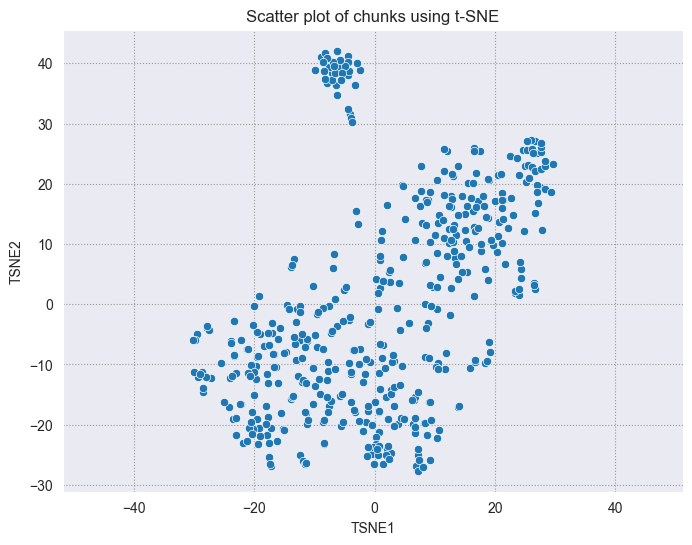

In [151]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2')
plt.title("Scatter plot of chunks using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Color Codeded By Similarity To Prompt

In [152]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
similarity = np.dot(query_embed, chunks_embed_db.T)
df_tsne['similarity'] = similarity.tolist()

(-33.22208118438721, 32.6836519241333, -31.15357494354248, 45.576422691345215)

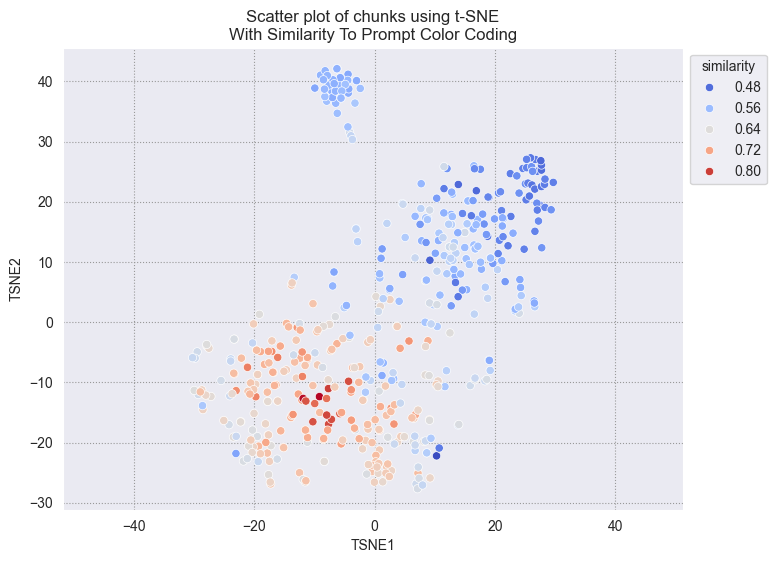

In [153]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Call Out Matches

In [154]:
matches = chunk_match(question)
df_tsne.iloc[[match[0] for match in matches]]

,TSNE1,TSNE2,similarity
275,-9.147479,-12.369026,0.823332
258,-11.860353,-12.668758,0.819694
105,-7.655019,-11.038074,0.799392
401,-7.941494,-15.431033,0.793455


(-33.22208118438721, 32.6836519241333, -31.15357494354248, 45.576422691345215)

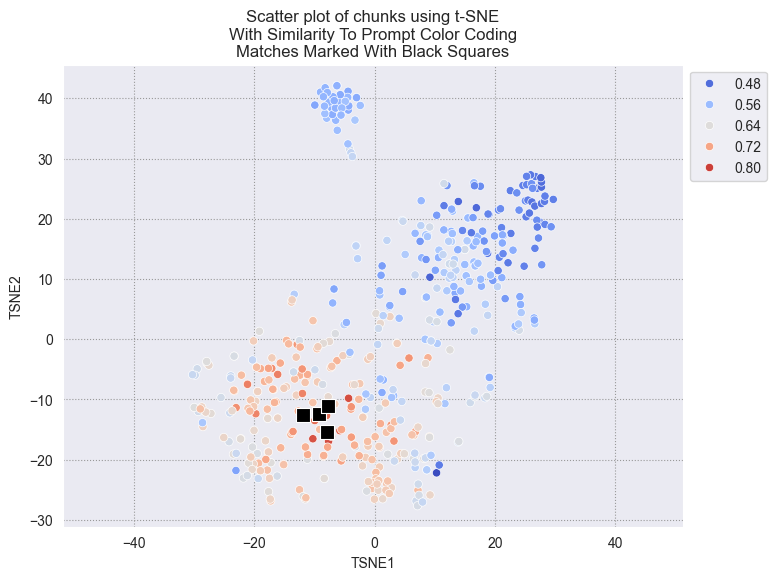

In [155]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.scatterplot(data = df_tsne.iloc[[match[0] for match in matches]], x="TSNE1", y="TSNE2", color = 'black', marker = 's', s = 100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding\nMatches Marked With Black Squares")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

## Make a function that receives the users questions and:

* finds and retrieves relative sections of the rules
* prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
* Retrieves the response (answer) from Vertex AI Generative AI
* Retrieves the closest match section of the rules to the response/answer.
* Prepares and presents all the information back to the user

### Functions For Bot
Retrieval Functions
These retrieve context.

In [156]:
def get_chunks(query, k = -1, simk = -1):
    # k set the number of matches to retrieve, regarless of similarity. k = -1 will trigger calculating k dynamically.
    # simk sets a threshold for similarity: <=0 uses k, (0,1] will get all matches with similarity in range [1-simk, 1] 
    
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T) # for dot product, higher is better match, since normalized embeddings 1 is best, 0 is worst
    matches = np.argsort(similarity)[::-1].tolist()
    
    if k <= 0:
        # algorithm to dynamically pick k
        k = 1 + 3*int(10*(1-similarity[matches[0]]))
    if simk <= 0:
        matches = [(match, similarity[match]) for match in matches[0:k]]
    elif simk > 0 and simk <= 1:
        indicies = np.where(similarity >= 1-simk)[0]
        matches = [(i, similarity[i]) for i in indicies]
     
    return matches

def expand_retrieval(contexts, DISTANCE):
    
    additional_contexts = []
    if DISTANCE > 0:
        
        # for each page look for surrounding chunks, collect chunks
        chunk_indexes = []
        for context in contexts:
            # get matches for the page from contexts
            matches = get_retrieval(context[2], simk = DISTANCE, file_page = (context[3]['file_index'], context[3]['page_index']))
            for match in matches:
                if match[0] not in chunk_indexes and match[0] not in [c[0] for c in contexts]:
                    chunk_indexes += [match[0]]
                    additional_contexts.append(match)

    return additional_contexts

def get_retrieval(question, k = -1, simk = -1, DISTANCE = 0, file_page = None):

    if file_page: # this is from a call to this function by expand_retrieval
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], True) for match in get_chunks(question, k = k, simk = simk) if file_page == (files_pages_chunks[match[0]]['metadata']['file_index'], files_pages_chunks[match[0]]['metadata']['page_index'])]
    else: # this is from a call to this function by the main function: document_bot
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], False) for match in get_chunks(question, k = k, simk = simk)]
    
    if DISTANCE > 0:
        matches = matches + expand_retrieval(matches, DISTANCE)
    
    return matches

### Augmentation Functions
* This function prepares the prompt by also adding retrieved context = augmenting.

In [157]:
def get_augmented(question, contexts, ground):
    prompt = ''
    
    if ground:
        prompt += "Give a detailed answer to the question using only the information from the numbered contexts provided below."
        prompt += "\n\nContexts:\n"
        prompt += "\n".join([f'  * Context {c+1}: "{context[2]}"' for c, context in enumerate(contexts)])
        prompt += "\n\nQuestion: " + question
    else:
        prompt += "Question: " + question
        
    # add the trigger to the prompt.  In this case, also include the zero shot chain of thought prompt "think step by step".
    prompt += "\n\nAnswer the question and give and explanation. Think step by step."
    
    return prompt

### Generation Functions
* These functions interact with LLMs to create responses.

In [158]:
def generate_gemini(prompt, genconfigs, model):
    response = model.generate_content(
        prompt,
        generation_config = vertexai.generative_models.GenerationConfig(
            **genconfigs
            
        )
    )

    try:
        text = response.text
    except Exception:
        text = None

    counter = 0
    while not text:
        genconfigs['temperature'] = .5 - counter*.1
        response = model.generate_content(
            prompt,
            generation_config = vertexai.generative_models.GenerationConfig(
                **genconfigs

            )
        )
        try:
            text = response.text
        except Exception:
            text = None
            counter += 1

        if counter == 6:
            text = 'Please check the prompt, it appears the response is getting blocked.'
    
    return text

def generate_palm(prompt, genconfigs, model):
    response = model.predict(
        prompt,
        **genconfigs
    )
    
    return response.text

def get_generation(prompt, max_output_tokens, model):
    models = dict(GEMINI = gemini_text, PALM_BISON = text_model_b, PALM_BISION32k = text_model_b32, PALM_UNICORN = text_model_u)
    
    genconfigs = dict(max_output_tokens = max_output_tokens)
    
    if model == 'GEMINI':
        response = generate_gemini(prompt, genconfigs, models[model])
    else:
        response = generate_palm(prompt, genconfigs, models[model])
    
    return response

### Presentation Functions
* These prepare the response for presentation - and display the results.

In [159]:
# get a font to use for annotating the page images:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

def get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations):
    # repeat the question
    IPython.display.display(IPython.display.Markdown(f'**The Question:**\n\n{question}\n\n'))
    
    # show the answer
    IPython.display.display(IPython.display.Markdown(f'**The Response:**\n\n{response}\n\n'))
    
    if display_contexts:
    # display the contexts information: page, similarity, hyperlink
        context_pres = '**Sources:**\n\n'
        pages = []
        context_types = [c[4] for c in contexts]
        if DISTANCE > 0:
            context_pres += f'Note: The {len(contexts) - sum(context_types)} contexts were expanded to gather {sum(context_types)} additional chunks on pages with matches using a similarity distance of {DISTANCE}.\n'
        for context in contexts:
            page = next([d['parsing']['path'], d['parsing']['file'], d['parsing']['page'], d['file_index'], d['page_index']] for d in files_pages if d['file_index'] == context[3]['file_index'] and d['page_index'] == context[3]['page_index'])
            pages.append(page)
            if not context[4]:
                context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to question is {context[1]:.3f}\n'
            # the following is commented out, if uncommented it would also add the expanded contexts to printed list (this can be very long for DISTANCE = 1 which is the full page)
            #else:
            #    context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to primary context is {context[1]:.3f}\n'
        IPython.display.display(IPython.display.Markdown(context_pres))
        
    if display_annotations:
    # display each page with annotations
        IPython.display.display(IPython.display.Markdown('**Annotated Document Pages**\n\n'))
        # list of unique pages across contexts: sorted list of tuple(file_index, page_index)
        pages = sorted(list(set([(page[3], page[4]) for page in pages])), key = lambda x: (x[0], x[1]))
        # list of PIL images for each unique page
        images = []
        for page in pages:
            image = next(d['parsing']['pages'][0]['image']['content'] for d in files_pages if d['file_index'] == page[0] and d['page_index'] == page[1])
            images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            image.encode('utf-8')
                        )
                    )
                )
            )
        # annotate the contexts on the pages:
        for c, context in enumerate(contexts):
            image = images[pages.index((context[3]['file_index'], context[3]['page_index']))]
            vertices = context[3]['vertices']
            draw = PIL.ImageDraw.Draw(image)
            if not context[4]: 
                color = 'green'
                prefix = 'Source'
            else:
                color = 'blue'
                prefix = 'Expanded Source'
            draw.polygon([
                vertices[0]['x'], vertices[0]['y'],
                vertices[1]['x'], vertices[1]['y'],
                vertices[2]['x'], vertices[2]['y'],
                vertices[3]['x'], vertices[3]['y']
            ], outline = color, width = 5)
            draw.text(
                xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {c+1}", fill = color, anchor = 'rd', font = font
            )
        
        for image in images:
            IPython.display.display(image.resize(tuple([int(.25*x) for x in image.size])))
            
    return

In [160]:
def document_bot(question, max_output_tokens = 1000, DISTANCE = 0, MODEL = 'GEMINI', display_contexts = False, display_annotations = False, ground = True):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on unique pages
    # MODEL = 'GEMINI' # one of: GEMINI, PALM_BISON, PALM_BISON32K, PALM_UNICORN
    
    # R: Retrival
    if ground:
        contexts = get_retrieval(question, DISTANCE = DISTANCE)
    else:
        contexts = []
        
    # A: Augemented
    prompt = get_augmented(question, contexts, ground)
    
    # G: Generation
    response = get_generation(prompt, max_output_tokens, MODEL)
    
    # Present Answer
    get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations)
    
    return prompt

### Try Out Document_Bot:

In [171]:
#question ="What is the process for filing an appeal if a claim is denied?"
question = "what is considered emergency"

#### Ungrounded response

In [172]:
prompt = document_bot(question, ground = False)

**The Question:**

what is considered emergency



**The Response:**

**Step 1: Define emergency**

An emergency is a sudden, unexpected situation that requires immediate action to prevent harm or danger. It can be caused by natural disasters, accidents, or medical conditions.

**Step 2: Identify the key characteristics of an emergency**

* **Sudden and unexpected:** Emergencies happen without warning and can catch you off guard.
* **Urgent:** They require immediate action to prevent harm or danger.
* **Threatening:** Emergencies can threaten your life, health, property, or environment.

**Step 3: Examples of emergencies**

Some common examples of emergencies include:

* Natural disasters (e.g., earthquakes, floods, hurricanes)
* Accidents (e.g., car crashes, falls, fires)
* Medical conditions (e.g., heart attacks, strokes, allergic reactions)

**Therefore, the answer to "what is considered an emergency" is:**

An emergency is a sudden, unexpected situation that requires immediate action to prevent harm or danger. It can be caused by natural disasters, accidents, or medical conditions.



#### Grounded Response

In [173]:
prompt = document_bot(question)

**The Question:**

what is considered emergency



**The Response:**

**Step 1: Locate the definition of "emergency"**

Context 3 states: "An "emergency" medical condition is an illness, injury, symptom (including severe pain) or condition severe enough to risk serious danger to your health if you don't get medical attention right away."

**Step 2: Summarize the definition**

An emergency is a medical condition that poses a serious risk to health if not treated promptly.

**Step 3: State the answer**

Therefore, an emergency is a medical condition that poses a serious risk to health if not treated promptly.



In [174]:
prompt = document_bot(question, display_contexts = True)

**The Question:**

what is considered emergency



**The Response:**

Step 1: Identify the context that defines "emergency."
Context 3 defines "emergency" as a medical condition that poses a serious danger to health if not treated promptly.

Step 2: Extract the specific criteria for an emergency.
Context 3 states that an emergency is a condition where one of the following can reasonably be expected if medical attention is not received:
- Serious danger to health
- Serious problems with bodily functions
- Serious damage to any part of the body

Step 3: Formulate the definition of "emergency."
Based on the criteria, an emergency is defined as a medical condition that poses a serious risk to health or bodily functions, requiring immediate medical attention to prevent serious harm.



**Sources:**

1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.769
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.766
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.732
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.717
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=32
	* page: 32, similarity to question is 0.712
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.687
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.686


**The Question:**

what is considered emergency



**The Response:**

**Step 1:** Read the contexts to find the definition of "emergency."

**Step 2:** Context 3 provides the definition of an "emergency" medical condition: "An "emergency" medical condition is an illness, injury, symptom (including severe pain) or condition severe enough to risk serious danger to your health if you don't get medical attention right away."

**Step 3:** Therefore, an emergency is a medical condition that is severe enough to risk serious danger to your health if you do not get medical attention right away.

**Answer:** An emergency is a medical condition that is severe enough to risk serious danger to your health if you do not get medical attention right away.



**Sources:**

1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.769
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.766
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.732
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.717
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=32
	* page: 32, similarity to question is 0.712
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.687
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.686


**Annotated Document Pages**



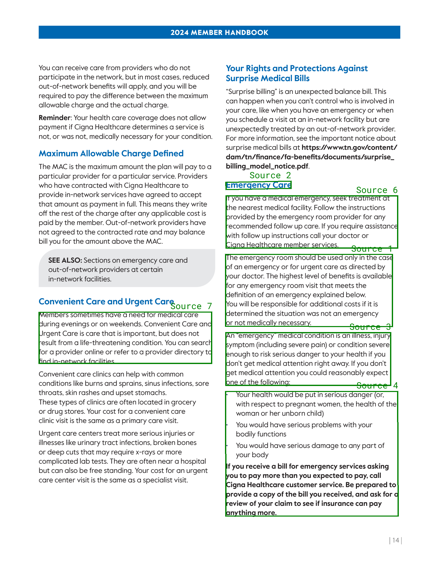

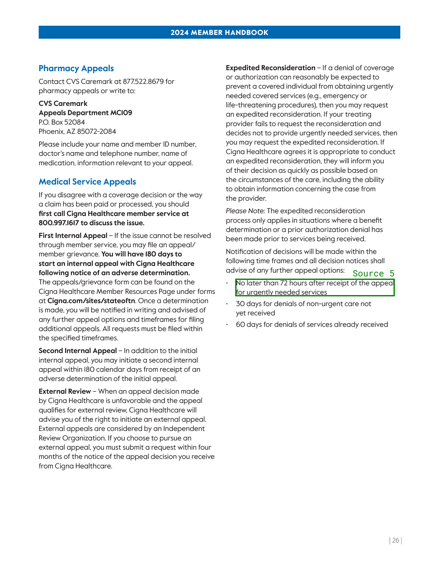

In [175]:
prompt = document_bot(question, display_contexts = True, display_annotations = True)

**The Question:**

what is considered emergency



**The Response:**

1. Look for the definition of an emergency in the provided contexts.
2. Find the context that includes the definition.
3. Read the definition carefully.

**Answer:**

According to Context 3, an "emergency" medical condition is:
* An illness, injury, symptom (including severe pain), or condition 
* Severe enough to risk serious danger to your health if you don't get medical attention right away.
* If you don't get medical attention, you could reasonably expect one of the following:
    * Your health would be put in serious danger (or, with respect to pregnant women, the health of the woman or her unborn child).
    * You would have serious problems with your bodily functions.
    * You would have serious damage to any part of your body.



**Sources:**

1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.769
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.766
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.732
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.717
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=32
	* page: 32, similarity to question is 0.712
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.687
1. https://www.tn.gov/content/dam/tn/partnersforhealth/documents/cigna_member_handbook_2024.pdf#page=20
	* page: 20, similarity to question is 0.686


**Annotated Document Pages**



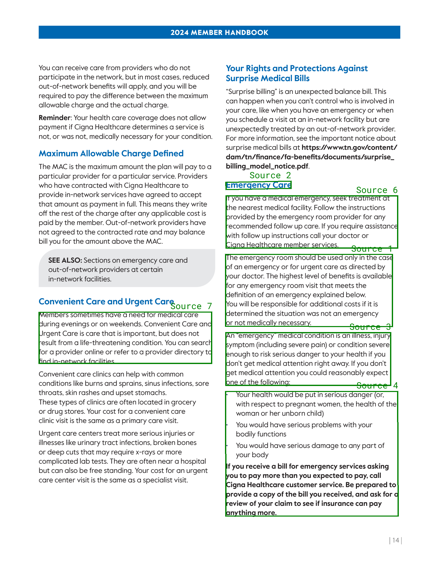

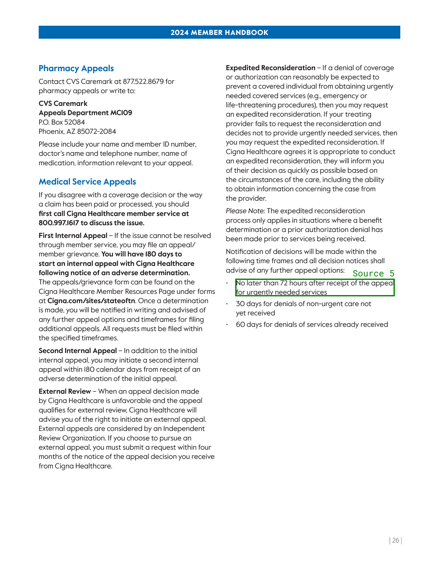

In [170]:
question ="what is considered emergency"
prompt = document_bot(question, DISTANCE = 0, display_contexts = True, display_annotations = True,ground=True)